<a href="https://colab.research.google.com/github/yashaswi2311/IBM-Stock-Prediction/blob/master/Stock_Market_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stock Market Prediction For IBM Stocks


In [0]:
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as pl
from pandas.plotting import scatter_matrix

##Stock market data capturing for IBM company


In [0]:
main_company = 'IBM'

# Compare with similar company
similar_company = ['MSFT','INTC']

In [54]:
# Define the date range
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2020, 3,31)

df = web.DataReader(main_company, 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-25,112.480003,102.830002,105.480003,105.849998,8654000.0,105.849998
2020-03-26,113.150002,105.570000,106.910004,112.889999,7153500.0,112.889999
2020-03-27,111.500000,107.650002,108.580002,108.029999,6423000.0,108.029999
2020-03-30,113.459999,107.809998,108.089996,112.930000,5564500.0,112.930000
2020-03-31,113.809998,110.169998,112.000000,110.930000,6343300.0,110.930000


## Data mining for IBM's stocks data


In [0]:
# Calculating the rolling mean for observation
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

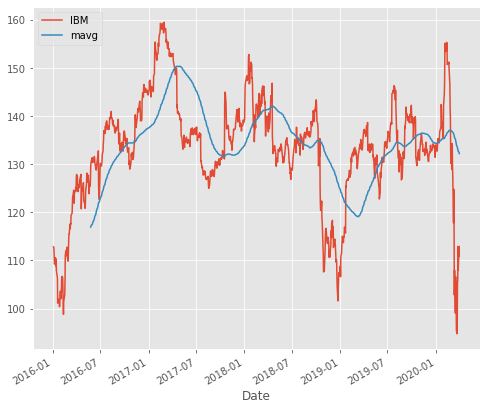

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label=main_company)
mavg.plot(label='mavg')
plt.legend()

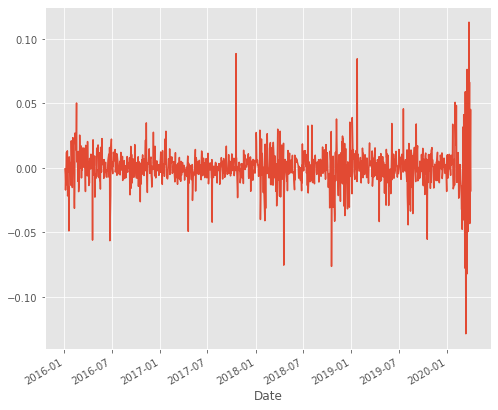

In [57]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

### Finding the Corelation among all the similar companies

In [58]:
dfcomp = web.DataReader([main_company, similar_company[0], similar_company[1]],'yahoo',start=start,end=end)['Adj Close']
dfcomp.tail()

Symbols,IBM,MSFT,INTC
Date,,,
2020-03-25,105.849998,146.919998,51.259998
2020-03-26,112.889999,156.110001,55.540001
2020-03-27,108.029999,149.699997,52.369999
2020-03-30,112.930000,160.229996,55.490002
2020-03-31,110.930000,157.710007,54.119999


In [59]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()
corr

Symbols,IBM,MSFT,INTC
Symbols,,,
IBM,1.000000,0.596076,0.543404
MSFT,0.596076,1.000000,0.692485
INTC,0.543404,0.692485,1.000000


Text(0, 0.5, 'Returns_MSFT')

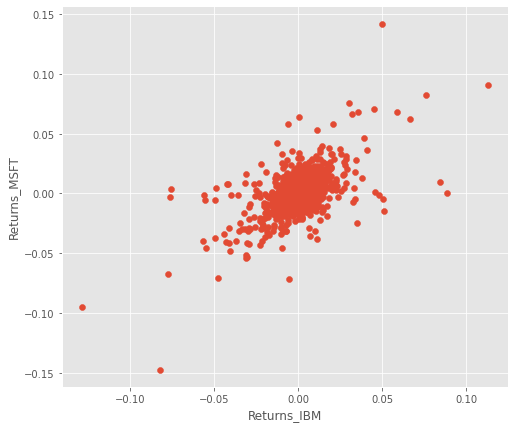

In [60]:
plt.scatter(retscomp[main_company], retscomp[similar_company[0]])
plt.xlabel('Returns_'+main_company)
plt.ylabel('Returns_'+similar_company[0])

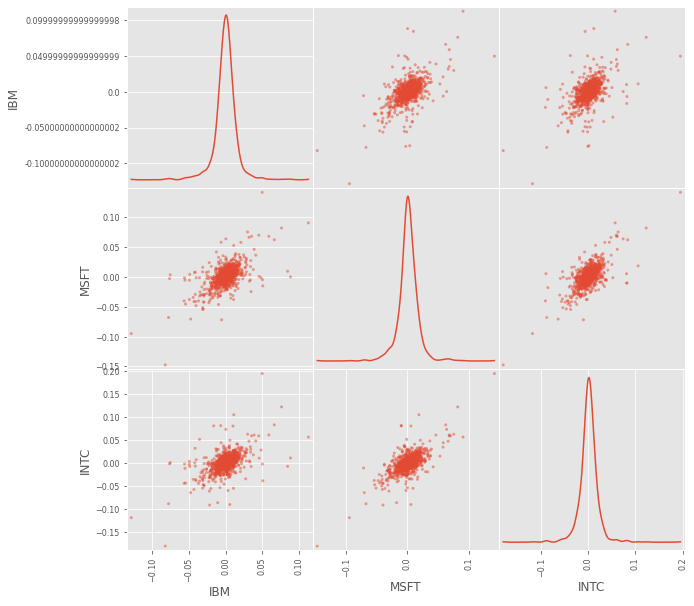

In [61]:
scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

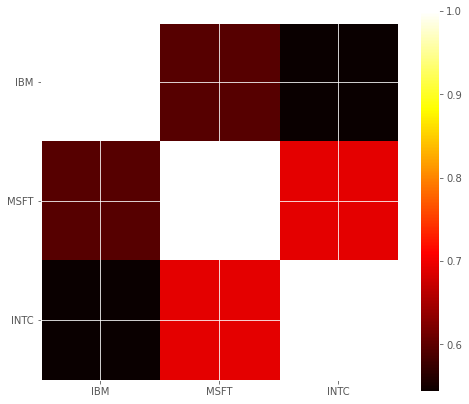

In [62]:
# Display Heatmap to identify the corelation between similar companies
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

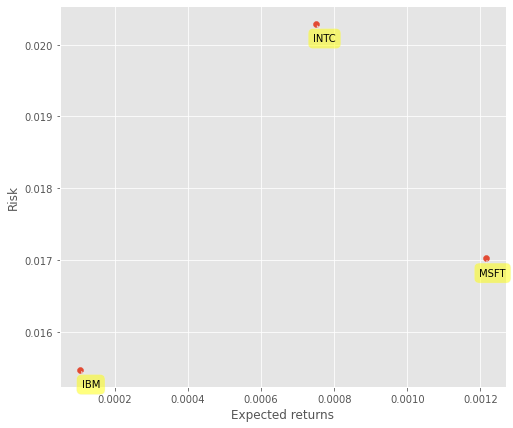

In [63]:
# Identify the risk on stock 
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

## Data Preprocessing

In [64]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2020-03-25,105.849998,8654000.0,9.116676,0.350773
2020-03-26,112.889999,7153500.0,6.714502,5.593486
2020-03-27,108.029999,6423000.0,3.563823,-0.506542
2020-03-30,112.930000,5564500.0,5.003101,4.477754
2020-03-31,110.930000,6343300.0,3.281348,-0.955357


In [0]:
import math
from sklearn import preprocessing

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]
y_lately = y[-forecast_out:]

## Prediction using Linear Models

In [0]:
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge, Ridge
from sklearn.preprocessing import PolynomialFeatures

In [67]:
X_train = X
y_train = y

# 1. Linear regression 
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# 2. Lasso - Linear Model
clflasso = Lasso(alpha=0.1)
clflasso.fit(X_train, y_train)

# 3. Bayesian Ridge - Linear Model
clfbr = BayesianRidge()
clfbr.fit(X_train, y_train)

# 4 Ridge - Linear Model
clfridge = Ridge(alpha=1.0)
clfridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [68]:
X_test = X_lately
y_test = y_lately

confidence_reg = clfreg.score(X_test, y_test)
confidence_lasso = clflasso.score(X_test,y_test)
confidence_br = clfbr.score(X_test,y_test)
confidence_ridge = clfridge.score(X_test, y_test)

print("confidencereg : ",confidence_reg)
print("confidence_lasso : ",confidence_lasso)
print("confidence_br : ",confidence_br)
print("confidence_ridge : ",confidence_ridge)

confidencereg :  0.8864796724559221
confidence_lasso :  0.8789193980537584
confidence_br :  0.8859706217915533
confidence_ridge :  0.8862392065932791


In [0]:
dfreg_lr = dfreg.copy()
dfreg_lasso = dfreg.copy()
dfreg_ridge = dfreg.copy()
dfreg_br = dfreg.copy()

noOfDaysData = 100

### 1. Prediction using Linear Regression 

In [70]:
forecast_set_linear_regression = clfreg.predict(X_lately)
dfreg_lr['Forecast_linear_regression'] =  np.nan
print(forecast_set_linear_regression)

[103.09049461 103.27776826 101.75553961  95.32367775  95.03867593
 106.24665624 102.00143273 111.82428131 110.68680919 113.99807933
 113.19542148]


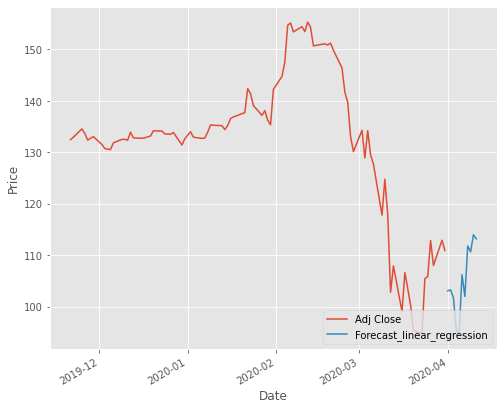

In [71]:
last_date = dfreg_lr.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_linear_regression:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg_lr.loc[next_date] = [np.nan for _ in range(len(dfreg_lr.columns)-1)]+[i]
dfreg_lr['Adj Close'].tail(noOfDaysData).plot()
dfreg_lr['Forecast_linear_regression'].tail(noOfDaysData).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### 2. Prediction Using Lasso - Linear model

In [72]:
forecast_set_lasso = clflasso.predict(X_lately)
dfreg_lasso['Forecast_lasso'] =  np.nan
print(forecast_set_lasso)

[103.22387549 103.47205911 102.46629662  96.52540703  95.72197639
 106.23380158 102.65686751 111.75090543 111.06032879 113.9072569
 113.57701714]


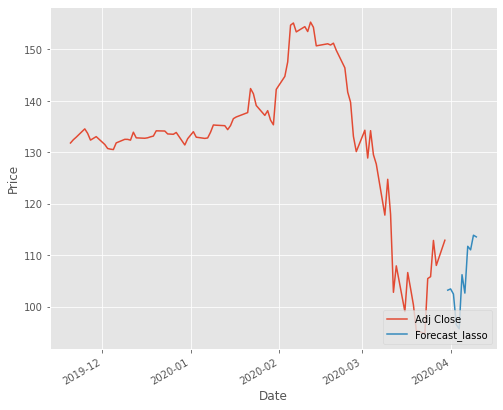

In [73]:
last_date = dfreg_lasso.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=0)

for i in forecast_set_lasso:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg_lasso.loc[next_date] = [np.nan for _ in range(len(dfreg_lasso.columns)-1)]+[i]
dfreg_lasso['Adj Close'].tail(noOfDaysData).plot()
dfreg_lasso['Forecast_lasso'].tail(noOfDaysData).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### 3. Prediction Using Bayesian Ridge - Linear model


In [74]:
forecast_set_bayesian_ridge = clfbr.predict(X_lately)
dfreg_br['Forecast_bayesian_ridge'] = np.nan
print(forecast_set_bayesian_ridge)

[103.11215582 103.31132677 101.79952906  95.37206287  95.08582492
 106.27956834 102.02597546 111.84414622 110.72360851 114.02307138
 113.22810104]


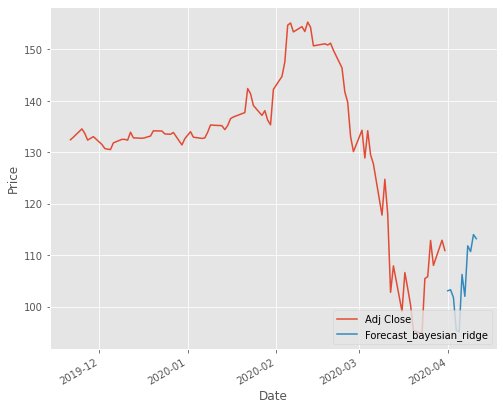

In [75]:
last_date = dfreg_br.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_bayesian_ridge:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg_br.loc[next_date] = [np.nan for _ in range(len(dfreg_br.columns)-1)]+[i]
dfreg_br['Adj Close'].tail(noOfDaysData).plot()
dfreg_br['Forecast_bayesian_ridge'].tail(noOfDaysData).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### 4. Prediction Using Ridge - Linear model

In [76]:
forecast_set_ridge = clfridge.predict(X_lately)
dfreg_ridge['Forecast_ridge'] =  np.nan
print(forecast_set_ridge)

[103.10101533 103.29409535 101.77695637  95.34723208  95.06162349
 106.26267165 102.01335941 111.8339385  110.70473001 114.01024114
 113.21133628]


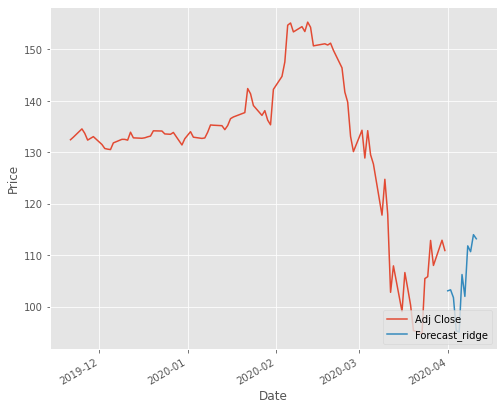

In [77]:
last_date = dfreg_ridge.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_ridge:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg_ridge.loc[next_date] = [np.nan for _ in range(len(dfreg_ridge.columns)-1)]+[i]
dfreg_ridge['Adj Close'].tail(noOfDaysData).plot()
dfreg_ridge['Forecast_ridge'].tail(noOfDaysData).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()